In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [9]:
import yfinance as yf

In [86]:
# df = pd.read_csv('https://senate-stock-watcher-data.s3-us-west-2.amazonaws.com/aggregate/all_transactions.csv')
df.transaction_date = pd.to_datetime(df.transaction_date)
df.disclosure_date = pd.to_datetime(df.disclosure_date)
df['Delta'] = (df.disclosure_date - df.transaction_date).astype('timedelta64[D]')
df = df[(df.asset_type == 'Stock') & (df.type.str.contains('Purchase')) & (df.Delta < 250)]

df['geometric_amount'] = df.amount.str.replace('$', '')\
                                  .str.replace(',', '')\
                                  .str.split(' - ', expand=True)\
                                  .astype(int).apply(lambda x: np.sqrt(x[0] * x[1]), axis=1)



/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  import sys


In [87]:
tsla_df = yf.download(df.ticker.dropna().unique().tolist())
stocks = tsla_df.loc[tsla_df.index > dt.datetime(2014, 1, 1)].dropna(how='all')
found = [s[1] for s in stocks.columns]

[*********************100%***********************]  609 of 609 completed

56 Failed downloads:
- UA-C: No data found, symbol may be delisted
- LLTC: None
- RAI: No data found for this date range, symbol may be delisted
- EQM: No data found, symbol may be delisted
- DLPH: No data found, symbol may be delisted
- FDC: No data found, symbol may be delisted
- AXLL: No data found for this date range, symbol may be delisted
- STI: No data found, symbol may be delisted
- WTW: No data found, symbol may be delisted
- UN: No data found, symbol may be delisted
- PHLD: No data found, symbol may be delisted
- RHT: No data found, symbol may be delisted
- MIK: No data found, symbol may be delisted
- EV: No data found, symbol may be delisted
- MSTY.PA: No data found, symbol may be delisted
- USG: No data found, symbol may be delisted
- CBS: No data found, symbol may be delisted
- AVP: No data found, symbol may be delisted
- ANDX: No data found, symbol may be delisted
- Q: No data found for this date ra

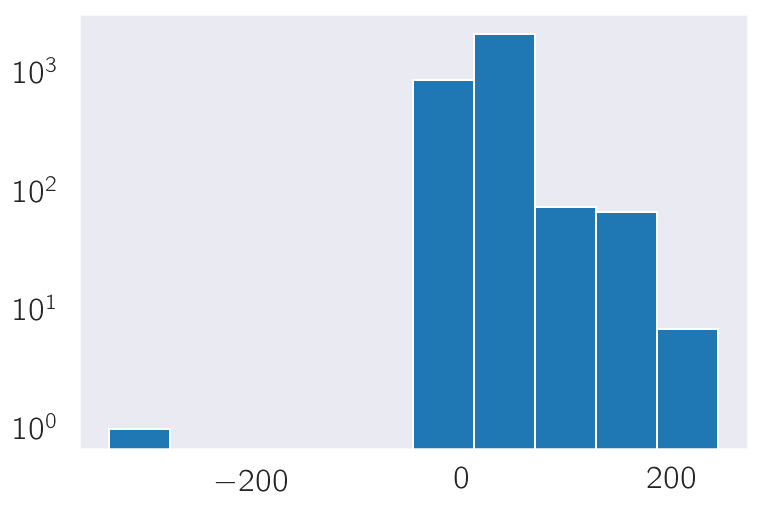

In [88]:
plt.hist((df.disclosure_date - df.transaction_date).astype('timedelta64[D]'))
plt.yscale('log')

count    3.241000e+03
mean     3.195649e+04
std      6.543480e+05
min      3.874919e+03
25%      3.874919e+03
50%      3.874919e+03
75%      3.874919e+03
max      3.535534e+07
Name: geometric_amount, dtype: float64

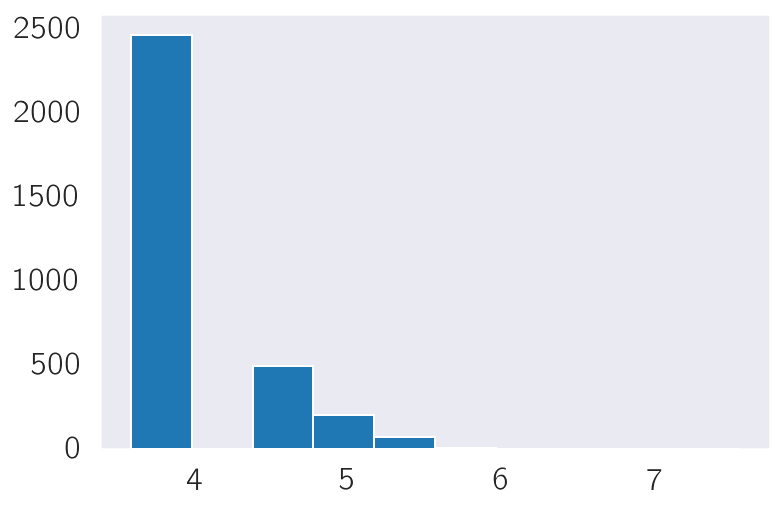

In [89]:
plt.hist(df.geometric_amount.apply(np.log10))
df.geometric_amount.describe()

In [173]:
V = []
D = []
T = []
G = []
P = []
for ticker, group in df.groupby('ticker'):
    if (ticker not in found) or (ticker == '--'):
        continue
    try:
        value = stocks.loc[group.transaction_date.unique()][('Open', ticker)].to_list()
        D += np.datetime_as_string(group.transaction_date.unique()).tolist()
        T += [ticker] * group.transaction_date.nunique()
        V += value
        G += group.groupby('transaction_date').geometric_amount.sum().to_list()
        P += group.groupby('transaction_date').senator.unique().to_list()
    except:
        continue

data = pd.DataFrame(zip(T, D, V, G, P), columns=['ticker', 'transaction_date', 'open_value', 'geometric_amount', 'buyers'])
data.transaction_date = pd.to_datetime(data.transaction_date)

In [174]:
data.sort_values("transaction_date")

,ticker,transaction_date,open_value,geometric_amount,buyers
719,DD,2014-09-15,75.006317,3874.919354,[Kelly Loeffler]
1567,MDDVX,2014-12-10,25.670000,7749.838708,[Susan M Collins]
1586,MIK,2014-12-11,NaN,3874.919354,[Pat Roberts]
835,DVFAX,2014-12-11,15.940000,3874.919354,[Susan M Collins]
2413,WASCX,2014-12-11,24.799999,3874.919354,[Susan M Collins]
...,...,...,...,...,...
2101,SNOW,2021-10-22,340.390015,3874.919354,[Thomas R Carper]
2074,SCCO,2021-11-02,60.139999,158114.673576,[Thomas H Tuberville]
544,CLF,2021-11-08,23.500000,27387.040731,[Thomas H Tuberville]
1835,OFC,2021-11-29,26.270000,3874.919354,[Gary C Peters]


In [163]:
data['geometric_sum'] = G

In [171]:
group.groupby('transaction_date').senator.unique().to_list()

[array(['Pat Roberts'], dtype=object), array(['Pat Roberts'], dtype=object)]